## **Task 1: Data Understanding and Visualization:**

#### **1. Load and visualize images from a dataset stored in directories, where each subdirectory represents a class.**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


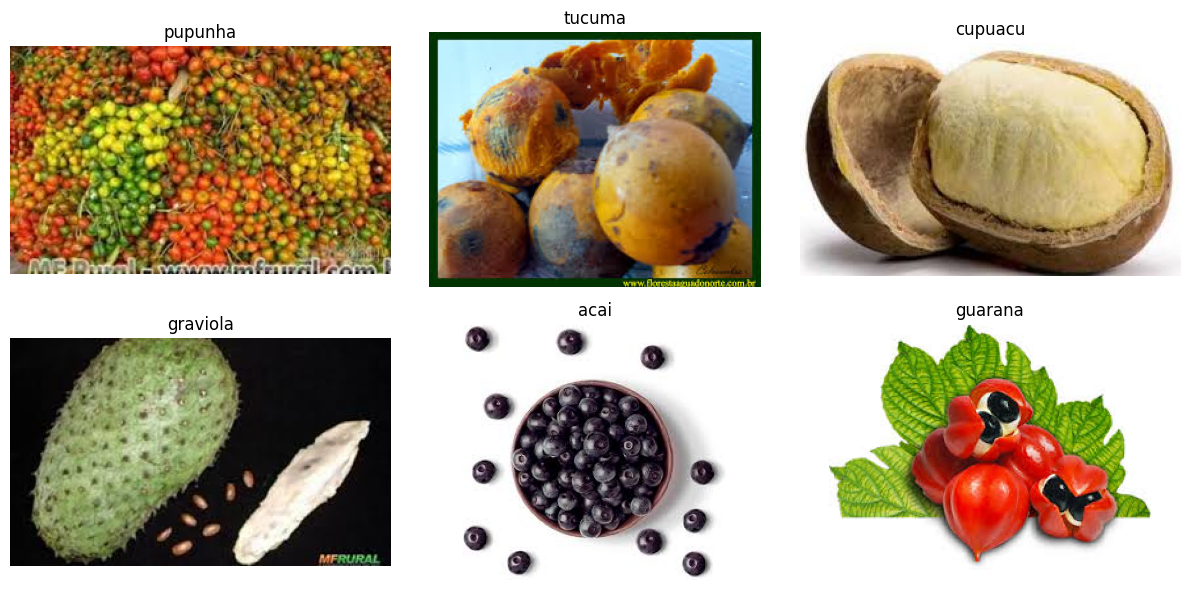

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the training dataset
train_dir = "/content/drive/MyDrive/FruitinAmazon/train"

# Get the list of class directories
fruit_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Select one random image from each fruit class
selected_images = []
for fruit in fruit_classes:
    fruit_path = os.path.join(train_dir, fruit)
    images = os.listdir(fruit_path)
    if images:
        random_image = random.choice(images)
        selected_images.append((fruit, os.path.join(fruit_path, random_image)))

# Determine grid size dynamically based on number of classes
num_classes = len(selected_images)
nrows = 2
ncols = (num_classes + 1) // 2

# Display images in a grid format
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))
axes = axes.flatten()

for ax, (label, img_path) in zip(axes, selected_images):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

for ax in axes[len(selected_images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

**What did you observe?**<br>
The code dynamically retrieves fruit categories and selects a random image from each folder and displays the image using matplotlib in a grid format with two rows, where there are three images in each row.

#### **Check for Corrupted Image:**

In [ ]:
import os
from PIL import Image

# Get the list of class directories (fruit categories)
fruit_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

corrupted_images = []

# Iterate through each class subdirectory
for fruit in fruit_classes:
    fruit_path = os.path.join(train_dir, fruit)
    images = os.listdir(fruit_path)

    for image in images:
        image_path = os.path.join(fruit_path, image)
        try:
            with Image.open(image_path) as img:
                img.verify()  # Verify if the image is valid
        except (IOError, SyntaxError):
            os.remove(image_path)  # Remove corrupted image
            corrupted_images.append(image_path)
            print(f"Removed corrupted image: {image_path}")

# Print result
if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


## **Task 2: Loading and Preprocessing Image Data in keras:**




In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
from sklearn.metrics import classification_report

# Parameters
img_height, img_width = 128, 128
batch_size = 16
validation_split = 0.2

# Load datasets with categorical labels (one-hot encoded)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',  # Crucial for categorical_crossentropy
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Get class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)

# Normalization
def preprocess(image, label):
    return image/255.0, label  # Normalize and keep one-hot labels

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


## **Task 3: Implement a CNN with**
**Follow the following structure and hyper-parameters:**<br>
**Convolutional Architecture**




In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Convolutional Layer 1
        layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2), strides=2),

        # Convolutional Layer 2
        layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Flatten Layer
        layers.Flatten(),

        # Fully Connected Layers
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

**Fully Connected Network Architecture**

## **Task 4: Compile the Model**
**Model Compilation**<br>

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## **Task 4: Train the Model**
**Model Training**<br>

In [ ]:
# Callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        'fruit_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,  # Higher patience for SGD
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_ds,
    epochs=250,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list,
    verbose=2
)

Epoch 1/250

Epoch 1: val_loss improved from inf to 1.14197, saving model to fruit_model.h5


5/5 - 6s - 1s/step - accuracy: 0.5278 - loss: 1.2858 - val_accuracy: 0.6667 - val_loss: 1.1420 - learning_rate: 0.0100
Epoch 2/250

Epoch 2: val_loss did not improve from 1.14197
5/5 - 5s - 1s/step - accuracy: 0.5417 - loss: 1.0756 - val_accuracy: 0.5556 - val_loss: 1.1926 - learning_rate: 0.0100
Epoch 3/250

Epoch 3: val_loss did not improve from 1.14197
5/5 - 4s - 889ms/step - accuracy: 0.6111 - loss: 1.0767 - val_accuracy: 0.5000 - val_loss: 1.4366 - learning_rate: 0.0100
Epoch 4/250

Epoch 4: val_loss did not improve from 1.14197
5/5 - 6s - 1s/step - accuracy: 0.6111 - loss: 1.2031 - val_accuracy: 0.5556 - val_loss: 1.3706 - learning_rate: 0.0100
Epoch 5/250

Epoch 5: val_loss improved from 1.14197 to 0.99837, saving model to fruit_model.h5


5/5 - 5s - 943ms/step - accuracy: 0.5000 - loss: 1.2674 - val_accuracy: 0.6111 - val_loss: 0.9984 - learning_rate: 0.0100
Epoch 6/250

Epoch 6: val_loss did not improve from 0.99837
5/5 - 5s - 1s/step - accuracy: 0.6806 - loss: 0.8189 - val_accuracy: 0.5000 - val_loss: 1.2173 - learning_rate: 0.0100
Epoch 7/250

Epoch 7: val_loss did not improve from 0.99837
5/5 - 11s - 2s/step - accuracy: 0.6250 - loss: 1.0377 - val_accuracy: 0.3889 - val_loss: 1.5571 - learning_rate: 0.0100
Epoch 8/250

Epoch 8: val_loss did not improve from 0.99837
5/5 - 15s - 3s/step - accuracy: 0.6111 - loss: 1.1438 - val_accuracy: 0.2778 - val_loss: 1.9921 - learning_rate: 0.0100
Epoch 9/250

Epoch 9: val_loss did not improve from 0.99837
5/5 - 12s - 2s/step - accuracy: 0.5833 - loss: 1.1035 - val_accuracy: 0.1111 - val_loss: 3.1488 - learning_rate: 0.0100
Epoch 10/250

Epoch 10: val_loss did not improve from 0.99837

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
5/5 - 4s - 875ms/ste

## **Task 5: Evaluate the Model**
**Model Evaluation**<br>

In [ ]:

# Load test dataset
test_dir = "/content/drive/MyDrive/FruitinAmazon/test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(128, 128),
    batch_size=16,
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (x / 255.0, y))  # Normalize test images

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Found 30 files belonging to 6 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3694 - loss: 1.8172
Test Accuracy: 0.3667, Test Loss: 1.8888


## **Task 6: Save and Load the Model**
**Model Saving and Loading**<br>

In [ ]:
# Save the trained model properly
model.save("/content/drive/MyDrive/FruitinAmazon/fruit_classifier.h5", save_format="h5")
print("Model saved successfully.")


Model saved successfully.


In [ ]:
# Reload the model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/FruitinAmazon/fruit_classifier.h5")
print("Model loaded successfully.")

# Print model summary
loaded_model.summary()


Model loaded successfully.


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 112,264 (438.54 KB)

 Trainable params: 111,430 (435.27 KB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 2 (12.00 B)

**Load the saved model and re-evaluate its performance on the test set.**

In [ ]:
# Prepare test data (must match training preprocessing)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
     "/content/drive/MyDrive/FruitinAmazon/test",
    labels='inferred',
    label_mode='categorical',  # Must be categorical
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
).map(lambda x, y: (x/255.0, y))  # Same normalization

# Re-evaluate correctly
loaded_loss, loaded_acc = loaded_model.evaluate(test_ds)
print(f"\nLoaded Model Test Accuracy: {loaded_acc:.4f}")
print(f"Loaded Model Test Loss: {loaded_acc:.4f}")

Found 30 files belonging to 6 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.3694 - loss: 1.8172

Loaded Model Test Accuracy: 0.3667
Loaded Model Test Loss: 0.3667


## **Task 7: Predictions and Classification Report**
**Making Predictions**<br>

In [ ]:
import numpy as np

# Make predictions on the test dataset
predictions = loaded_model.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step


**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Load the test dataset without mapping to get class names
raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/FruitinAmazon/test",
    image_size=(128, 128),
    batch_size=16,
    shuffle=False  # No shuffling to match predictions with labels
)

# Get class names from the dataset
class_names = raw_test_ds.class_names  # This works because raw_test_ds retains class names
print("Class Names:", class_names)

# Now, apply normalization again
test_ds = raw_test_ds.map(lambda x, y: (x / 255.0, y))

# Make predictions
predictions = loaded_model.predict(test_ds)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the dataset
true_labels = np.concatenate([y.numpy() for _, y in test_ds])

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)


Found 30 files belonging to 6 classes.
Class Names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
Classification Report:
               precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.33      0.60      0.43         5
    graviola       0.23      0.60      0.33         5
     guarana       0.00      0.00      0.00         5
     pupunha       0.75      0.60      0.67         5
      tucuma       0.50      0.40      0.44         5

    accuracy                           0.37        30
   macro avg       0.30      0.37      0.31        30
weighted avg       0.30      0.37      0.31        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Confusion Matrix**

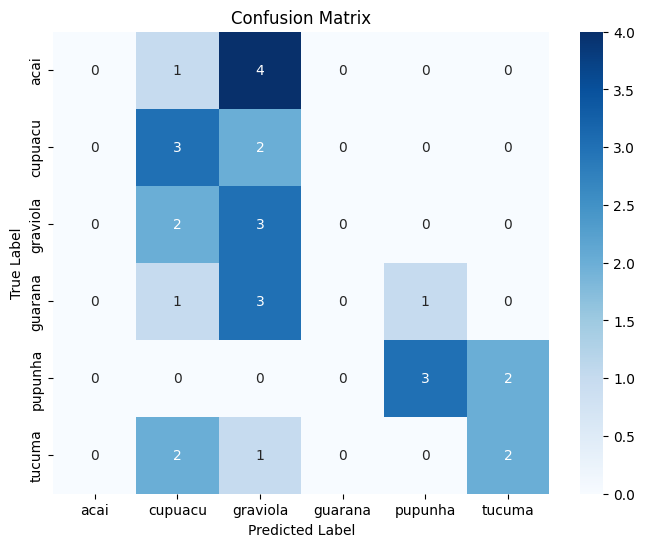

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
